In [1]:
from configparser import ConfigParser
import sqlalchemy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.accuracy import rmse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import reduce

In [2]:
def get_config(filename, section='postgresql'):
    parser = ConfigParser()
    parser.read(filename)
    db_params = {}
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            db_params[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, filename))
    return db_params

In [3]:
def get_query_results(queries):
    engine = None
    try:
        params = get_config(DATABASE_CONFIG)
        engine = sqlalchemy.create_engine('postgresql://' + params['user'] + ':' + params['password'] + '@' + params['host'] + ':' + params['port'] + '/' + params['database'])
        return tuple([pd.read_sql(query, con=engine) for query in queries])
    except (Exception) as error:
        print(error)
    finally:
        if engine is not None:
            engine.dispose()

In [4]:
DATABASE_CONFIG = 'database.ini'
USER_ASSESSMENT_QUERY = 'with norm as (select assessment_tag, avg(user_assessment_score) score_avg, stddev(user_assessment_score) score_stddev from user_assessment_scores group by assessment_tag) select user_handle, user_assessment_scores.assessment_tag, coalesce((user_assessment_score - norm.score_avg) / (norm.score_stddev + 1), 0) score_scaled from user_assessment_scores left join norm on user_assessment_scores.assessment_tag = norm.assessment_tag'
USER_COURSE_QUERY = 'with norm as (select course_id, avg(view_time_seconds) view_time_avg, stddev(view_time_seconds) view_time_stddev from user_course_views group by course_id), data as (select user_handle, course_id, sum(view_time_seconds) view_time from user_course_views group by user_handle, course_id) select data.user_handle, data.course_id, coalesce((data.view_time - norm.view_time_avg) / (norm.view_time_stddev + 1), 0) view_time_scaled from data left join norm on data.course_id = norm.course_id'
USER_INTEREST_QUERY = "select user_handle, string_agg(interest_tag, ', ') interest_tags from user_interests group by user_handle"
user_assessment_scores_df, user_course_views_df, user_interests_df = get_query_results([USER_ASSESSMENT_QUERY, USER_COURSE_QUERY, USER_INTEREST_QUERY])
print(user_assessment_scores_df.shape, user_course_views_df.shape, user_interests_df.shape)

(6571, 3) (105353, 3) (10000, 2)


In [5]:
def build_assessment_similarity_matrix():
    user_assessment_score_vectors = pd.pivot(user_assessment_scores_df, index='user_handle', columns='assessment_tag', values='score_scaled').fillna(0)
    print('User-assessment score matrix shape -', user_assessment_score_vectors.shape)
    return pd.DataFrame(cosine_similarity(user_assessment_score_vectors), columns=user_assessment_score_vectors.index, index=user_assessment_score_vectors.index)

In [6]:
def build_model(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42):
    reader = Reader(rating_scale=(min(user_course_views_df['view_time_scaled']), max(user_course_views_df['view_time_scaled'])))
    data = Dataset.load_from_df(user_course_views_df, reader)
    trainset = data.build_full_trainset()
    model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, random_state=random_state)
    model.fit(trainset)
    return model, rmse(model.test(trainset.build_testset())), trainset

In [7]:
def generate_elbow_plot(n_factors_range, random_state=42):
    results = {n_factors: build_model(n_factors=n_factors, n_epochs=N_EPOCHS, random_state=random_state)[1] for n_factors in n_factors_range}
    plt.figure()
    plt.plot(list(results.keys()), list(results.values()))
    plt.title('RMSE vs number of factors')
    plt.xlabel('Number of factors')
    plt.ylabel('RMSE')

In [8]:
def perform_grid_search(param_grid):
    results = {}
    for lr_all in param_grid['lr_all']:
        for reg_all in param_grid['reg_all']:
            results[(lr_all, reg_all)] = build_model(n_factors=N_FACTORS, n_epochs=N_EPOCHS, lr_all=lr_all, reg_all=reg_all)[1]
    best_params = min(results, key=results.get)
    print(best_params, results[best_params])

In [9]:
# baseline model
model, rmse_value, trainset = build_model()

RMSE: 0.9105


In [10]:
N_EPOCHS = 40

## Finding number of factors

RMSE: 0.8958
RMSE: 0.5461
RMSE: 0.3971
RMSE: 0.3417
RMSE: 0.2100
RMSE: 0.1594
RMSE: 0.1331
RMSE: 0.1185


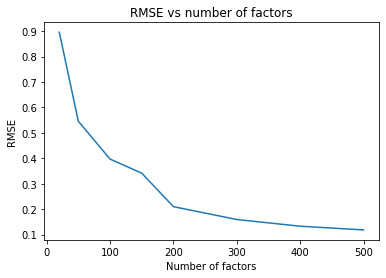

In [150]:
generate_elbow_plot([20, 50, 100, 150, 200, 300, 400, 500])

RMSE: 0.5461
RMSE: 0.4506
RMSE: 0.3662
RMSE: 0.3417
RMSE: 0.2292
RMSE: 0.2100
RMSE: 0.1934
RMSE: 0.1802


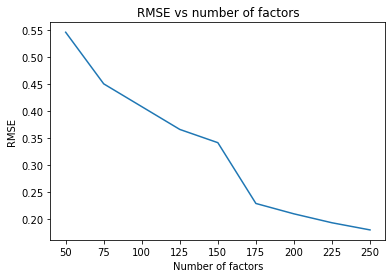

In [151]:
generate_elbow_plot([50, 75, 125, 150, 175, 200, 225, 250])

In [11]:
N_FACTORS = 175

## Finding learning rate

In [174]:
%%time
param_grid = {
    'lr_all': [0.002, 0.02],
    'reg_all': [0.02, 0.2]
}
perform_grid_search(param_grid)

RMSE: 0.9029
RMSE: 1.5242
RMSE: 229.2016
RMSE: 229.2016
(0.002, 0.02) 0.9028776549781232
Wall time: 1min 4s


In [175]:
%%time
param_grid = {
    'lr_all': [0.001, 0.002, 0.005],
    'reg_all': [0.02, 0.2]
}
perform_grid_search(param_grid)

RMSE: 1.7177
RMSE: 2.1558
RMSE: 0.9029
RMSE: 1.5242
RMSE: 0.2292
RMSE: 0.9648
(0.005, 0.02) 0.2291596113899946
Wall time: 1min 49s


In [176]:
%%time
param_grid = {
    'lr_all': [0.002, 0.005, 0.007, 0.01],
    'reg_all': [0.02, 0.2]
}
perform_grid_search(param_grid)

RMSE: 0.9029
RMSE: 1.5242
RMSE: 0.2292
RMSE: 0.9648
RMSE: 0.2254
RMSE: 1.0997
RMSE: 229.2016
RMSE: 229.2016
(0.007, 0.02) 0.22536162564784257
Wall time: 2min 42s


In [12]:
LR_ALL = 0.007

## Finding regularization parameter

In [179]:
%%time
param_grid = {
    'lr_all': [LR_ALL],
    'reg_all': [0.01, 0.02, 0.03, 0.04, 0.05]
}
perform_grid_search(param_grid)

RMSE: 0.4746
RMSE: 0.2254
RMSE: 0.1835
RMSE: 0.3946
RMSE: 0.2701
(0.007, 0.03) 0.1834922297059677
Wall time: 1min 24s


In [13]:
REG_ALL = 0.03

In [14]:
def save_factors(user_factors, course_factors):
    engine = None
    try:
        params = get_config(DATABASE_CONFIG)
        engine = sqlalchemy.create_engine('postgresql://' + params['user'] + ':' + params['password'] + '@' + params['host'] + ':' + params['port'] + '/' + params['database'])
        
        user_factors.to_sql('user_factors', engine, if_exists='replace')
        print('Table user_factors successfully created.')
        
        course_factors.to_sql('course_factors', engine, if_exists='replace')
        print('Table course_factors successfully created.')
    except (Exception) as error:
        print(error)
    finally:
        if engine is not None:
            engine.dispose()
            print('Database connection closed.')

In [15]:
def get_factors(model, trainset):
    user_factors = model.pu
    user_factors = np.hstack((user_factors, model.bu[..., None]))
    user_factors = pd.DataFrame.from_dict(dict(zip([trainset.to_raw_uid(user_id) for user_id in trainset.all_users()], user_factors)), orient='index')
    
    course_factors = model.qi
    course_factors = np.hstack((course_factors, model.bi[..., None]))
    course_factors = pd.DataFrame.from_dict(dict(zip([trainset.to_raw_iid(course_id) for course_id in trainset.all_items()], course_factors)), orient='index')
    save_factors(user_factors, course_factors)
    return user_factors, course_factors

In [106]:
USER_FACTORS_QUERY = 'select * from user_factors'
def build_course_similarity_matrix_from_model():
    '''Builds the course similarity matrix using normalized view times from trained model'''

    user_factors = get_query_results([USER_FACTORS_QUERY])[0]
    user_handles = user_factors[user_factors.columns[0]]
    user_factors.drop(user_factors.columns[0], axis=1, inplace=True)
    print('User-factors matrix shape -', user_factors.shape)
    return pd.DataFrame(cosine_similarity(user_factors), columns=user_handles, index=user_handles)

In [107]:
build_course_similarity_matrix_from_model()

User-factors matrix shape - (8760, 176)


index,1,2,3,4,5,6,8,9,10,12,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
index,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096273,-0.060019,0.021005,-0.053494,-0.165785,0.069499,0.021563,0.064851,-0.022480,...,0.065491,-0.025394,-0.038721,3.918923e-02,0.104345,0.005522,-0.087308,-0.076166,0.094094,-0.004989
2,0.096273,1.000000,-0.073179,-0.074273,-0.089949,-0.030801,0.073094,0.050279,-0.029789,0.112278,...,0.146009,0.010252,-0.015884,-3.380413e-02,-0.069590,-0.014876,0.010667,-0.033116,0.087446,-0.032383
3,-0.060019,-0.073179,1.000000,0.172700,-0.069501,-0.005398,-0.125039,0.014452,0.045722,0.145044,...,0.093070,0.007953,0.013739,-1.223774e-02,-0.151806,0.083285,0.169693,-0.015987,-0.023568,-0.077935
4,0.021005,-0.074273,0.172700,1.000000,-0.147186,0.062481,-0.046176,0.097253,0.094616,0.164043,...,-0.041616,0.006432,0.106659,-2.159168e-02,-0.235297,-0.011433,-0.084908,0.062964,0.021985,0.037626
5,-0.053494,-0.089949,-0.069501,-0.147186,1.000000,0.137323,0.054630,-0.121058,-0.012709,-0.144953,...,-0.124638,0.060810,-0.013511,-4.842261e-02,0.056483,0.004312,-0.055667,-0.081322,-0.077289,0.007743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.005522,-0.014876,0.083285,-0.011433,0.004312,0.007139,-0.037838,0.051450,0.112319,0.049063,...,0.116715,0.131076,-0.019652,1.464124e-01,-0.046090,1.000000,-0.043967,-0.067969,-0.032677,0.006362
9997,-0.087308,0.010667,0.169693,-0.084908,-0.055667,-0.034771,0.144678,0.073529,0.028042,-0.021190,...,-0.011338,0.045543,-0.154264,-1.439769e-07,0.064819,-0.043967,1.000000,0.014534,-0.021863,0.036059
9998,-0.076166,-0.033116,-0.015987,0.062964,-0.081322,0.015382,0.022708,0.084222,0.122779,0.145560,...,-0.009115,0.101660,0.080806,-3.986597e-02,-0.022095,-0.067969,0.014534,1.000000,-0.002259,-0.035888


In [16]:
def build_course_similarity_matrix():
    model, rmse_value, trainset = build_model(n_factors=N_FACTORS, n_epochs=N_EPOCHS, lr_all=LR_ALL, reg_all=REG_ALL)
    user_factors, course_factors = get_factors(model, trainset)
    print('User and course factors matrix shape -', user_factors.shape, course_factors.shape)
    return pd.DataFrame(cosine_similarity(user_factors), columns=user_factors.index, index=user_factors.index)

In [21]:
def build_interest_similarity_matrix():
    vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split(', '))
    vectors = vectorizer.fit_transform(user_interests_df['interest_tags'])
    print('User-interest matrix shape -', vectors.shape)
    return pd.DataFrame(cosine_similarity(vectors), columns=user_interests_df['user_handle'], index=user_interests_df['user_handle'])

In [18]:
ASSESSMENT_WEIGHT, COURSE_WEIGHT, INTEREST_WEIGHT = 0.5, 0.2, 0.3

In [24]:
def build_similarity_matrix():
    assessment_similarity_df = build_assessment_similarity_matrix()
    course_similarity_df = build_course_similarity_matrix()
    interest_similarity_df = build_interest_similarity_matrix()
    return assessment_similarity_df, course_similarity_df, interest_similarity_df, reduce(lambda a, b: a.add(b, fill_value=0), [assessment_similarity_df * ASSESSMENT_WEIGHT, course_similarity_df * COURSE_WEIGHT, interest_similarity_df * INTEREST_WEIGHT])

In [25]:
assessment_similarity_df, course_similarity_df, interest_similarity_df, similarity_df = build_similarity_matrix()

User-assessment score matrix shape - (3114, 54)
RMSE: 0.1835
Table user_factors successfully created.
Table course_factors successfully created.
Database connection closed.
User and course factors matrix shape - (8760, 176) (5942, 176)
User-interest matrix shape - (10000, 748)


In [95]:
def get_similar_users(user_handle):
    if user_handle not in similarity_df:
        raise Exception('User does not exist')
    
    user_top_assessment_tags = list(user_assessment_scores_df[user_assessment_scores_df['user_handle'] == user_handle].sort_values(by='score_scaled', ascending=False)['assessment_tag'])
    user_top_assessment_tags = user_top_assessment_tags if len(user_top_assessment_tags) < 3 else user_top_assessment_tags[:3]
    
    user_highest_course_views = list(user_course_views_df[user_course_views_df['user_handle'] == user_handle].sort_values(by='view_time_scaled', ascending=False)['course_id'])
    user_highest_course_views = user_highest_course_views if len(user_highest_course_views) < 3 else user_highest_course_views[:3]
    
    user_interest_tags = list(user_interests_df[user_interests_df['user_handle'] == user_handle]['interest_tags'])
    
    similar_users = assessment_similarity_df[user_handle].drop(labels=user_handle).sort_values(ascending=False)[:10] if user_handle in assessment_similarity_df else []
    similar_score_users = {'users': list(similar_users.index), 'similarities': list(similar_users.values)} if len(similar_users) > 0 else {}
    similar_users = course_similarity_df[user_handle].drop(labels=user_handle).sort_values(ascending=False)[:10] if user_handle in course_similarity_df else []
    similar_course_views_users = {'users': list(similar_users.index), 'similarities': list(similar_users.values)} if len(similar_users) > 0 else {}
    similar_users = interest_similarity_df[user_handle].drop(labels=user_handle).sort_values(ascending=False)[:10] if user_handle in interest_similarity_df else []
    similar_interest_users = {'users': list(similar_users.index), 'similarities': list(similar_users.values)} if len(similar_users) > 0 else {}
    similar_users = similarity_df[user_handle].drop(labels=user_handle).sort_values(ascending=False)[:10]
    similar_overall_users = {'users': list(similar_users.index), 'similarities': list(similar_users.values)}
    
    return {'user_top_assessment_tags': user_top_assessment_tags, 
            'user_highest_course_views': user_highest_course_views, 
            'user_interest_tags': user_interest_tags,
           'similar_score_users': similar_score_users,
           'similar_course_views_users': similar_course_views_users,
           'similar_interest_users': similar_interest_users,
           'similar_overall_users': similar_overall_users}

In [96]:
get_similar_users(2)

{'user_top_assessment_tags': ['photoshop'],
 'user_highest_course_views': ['intro-zbrush-4r7-2090',
  'high-resolution-game-char-creation-pipeline-zbrush-maya-1361',
  'game-prop-modeling-fundamentals'],
 'user_interest_tags': ['zbrush, maya, 3ds-max, adobe'],
 'similar_score_users': {'users': [3851,
   4005,
   6030,
   6917,
   3318,
   382,
   2056,
   625,
   7537,
   4608],
  'similarities': [1.0,
   1.0,
   0.9235972834487484,
   0.8939587892665225,
   0.7192522098894492,
   0.6563222843028201,
   0.655400171883239,
   0.49358261057245073,
   0.46871910423115865,
   0.4651248776411019]},
 'similar_course_views_users': {'users': [1826,
   5952,
   2015,
   2879,
   5081,
   4820,
   5109,
   2977,
   9112,
   8378],
  'similarities': [0.4498510235632364,
   0.34998701811157873,
   0.2946401499522206,
   0.2846420433079939,
   0.2787026564346413,
   0.27658778053062166,
   0.2642963719000827,
   0.2508883038705708,
   0.24671322237514698,
   0.24277208978238943]},
 'similar_interes

In [97]:
get_similar_users(3851)

{'user_top_assessment_tags': ['photoshop'],
 'user_highest_course_views': ['your-first-day-mari-1468'],
 'user_interest_tags': ['maya, 3d-texturing, zbrush, 3d-lighting, 3d-dynamics, 3d-rigging, 3d-animation, adobe'],
 'similar_score_users': {'users': [2,
   4005,
   6030,
   6917,
   3318,
   382,
   2056,
   625,
   7537,
   4608],
  'similarities': [1.0,
   1.0,
   0.9235972834487484,
   0.8939587892665225,
   0.7192522098894492,
   0.6563222843028201,
   0.655400171883239,
   0.49358261057245073,
   0.46871910423115865,
   0.4651248776411019]},
 'similar_course_views_users': {'users': [5104,
   4580,
   3872,
   9073,
   7039,
   1132,
   9872,
   8737,
   2458,
   2304],
  'similarities': [0.29323941470114334,
   0.26731685422117535,
   0.2586380335847158,
   0.25815389866525656,
   0.25489946571269817,
   0.2536206199491258,
   0.2502755726590581,
   0.24333851006177337,
   0.23720067359017144,
   0.23506348700202803]},
 'similar_interest_users': {'users': [6614,
   8866,
   6842